<img src="./pictures/Netflix.png" style="height: 100%; width:100%"/>


Netflix is one of the most popular media and video streaming platforms. They have over 8000 movies or tv shows available on their platform, as of mid-2021, they have over 200M Subscribers globally. This tabular dataset consists of listings of all the movies and tv shows available on Netflix, along with details such as - cast, directors, ratings, release year, duration, etc.
 
This goal of this project is to create a movie / tv-show recommendation system. When given a movie title, will generate the top 5 movie or shows to watch. The purpose of this project was to build my skills with recommendation systems and using NLP models.

#### Data

https://www.kaggle.com/datasets/shivamb/netflix-shows

NetFlix Data Co

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import re
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

#EDA and preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
data = pd.read_csv('./data/netflix_titles_1.csv')
print(f'Netflix movie data frame shape: {data.shape} \n')
data.head()

Netflix movie data frame shape: (8807, 12) 



,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,25-Sep-21,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,24-Sep-21,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,24-Sep-21,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,24-Sep-21,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,24-Sep-21,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [3]:
data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


## EDA

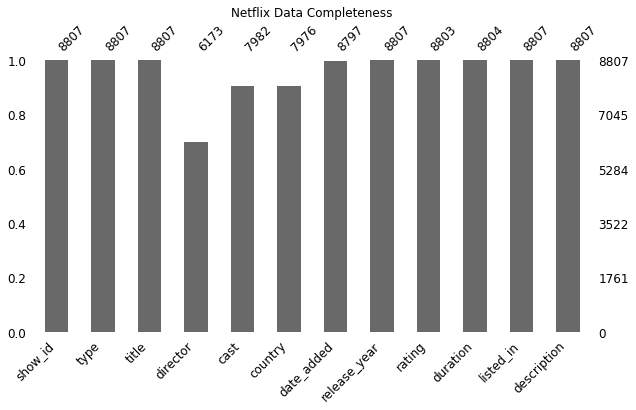

In [4]:
msno.bar(data, figsize=(10,5), fontsize=12);
plt.title("Netflix Data Completeness");

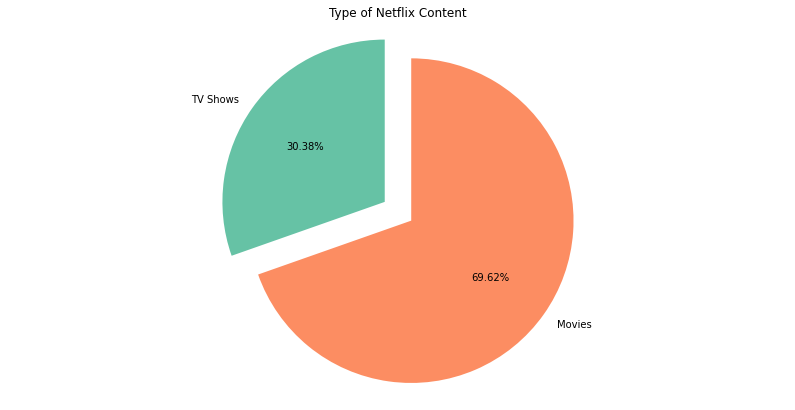

In [5]:
labels = ['TV Shows', 'Movies']
colors = sns.color_palette('Set2')
plt.figure(figsize=(14, 7))
plt.pie(data['type'].value_counts().sort_values(), labels = labels, colors = colors, autopct='%1.2f%%', explode=[0.1,0.1], startangle=90)
plt.title("Type of Netflix Content")
plt.axis('equal')
plt.show()

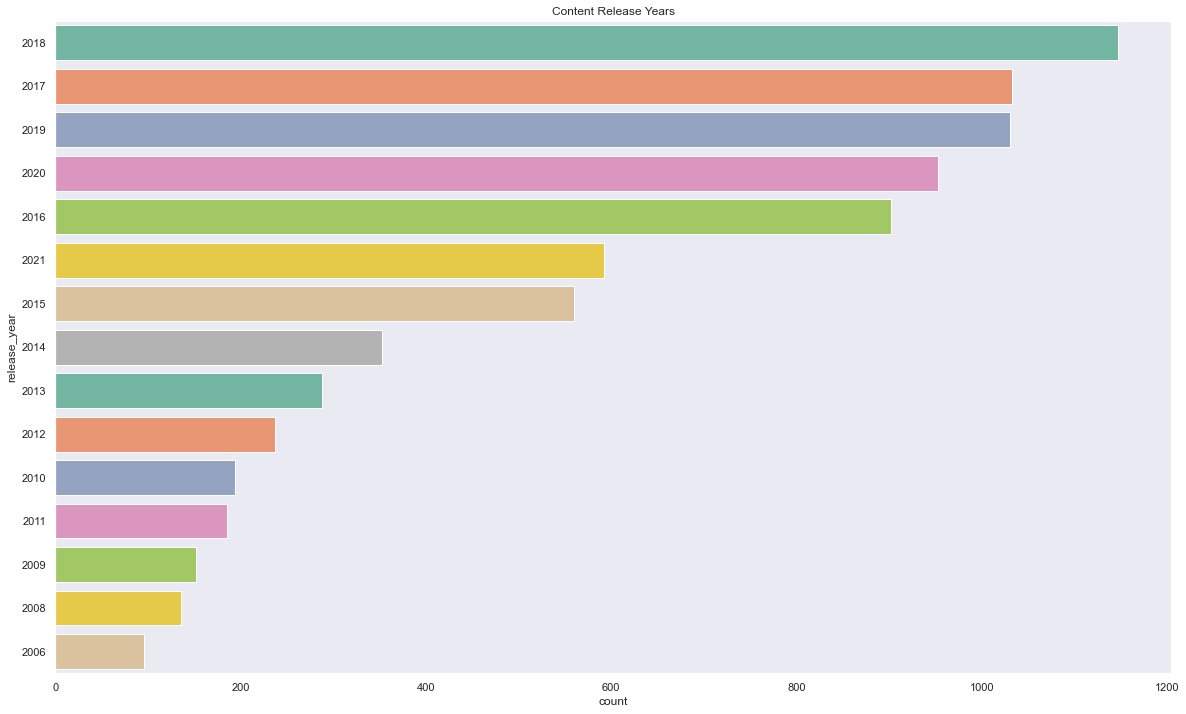

In [6]:
plt.figure(figsize=(20,12))
sns.set(style="dark")
sns.countplot(y="release_year", data=data, palette="Set2", order=data['release_year'].value_counts().index[0:15])
plt.title("Content Release Years");

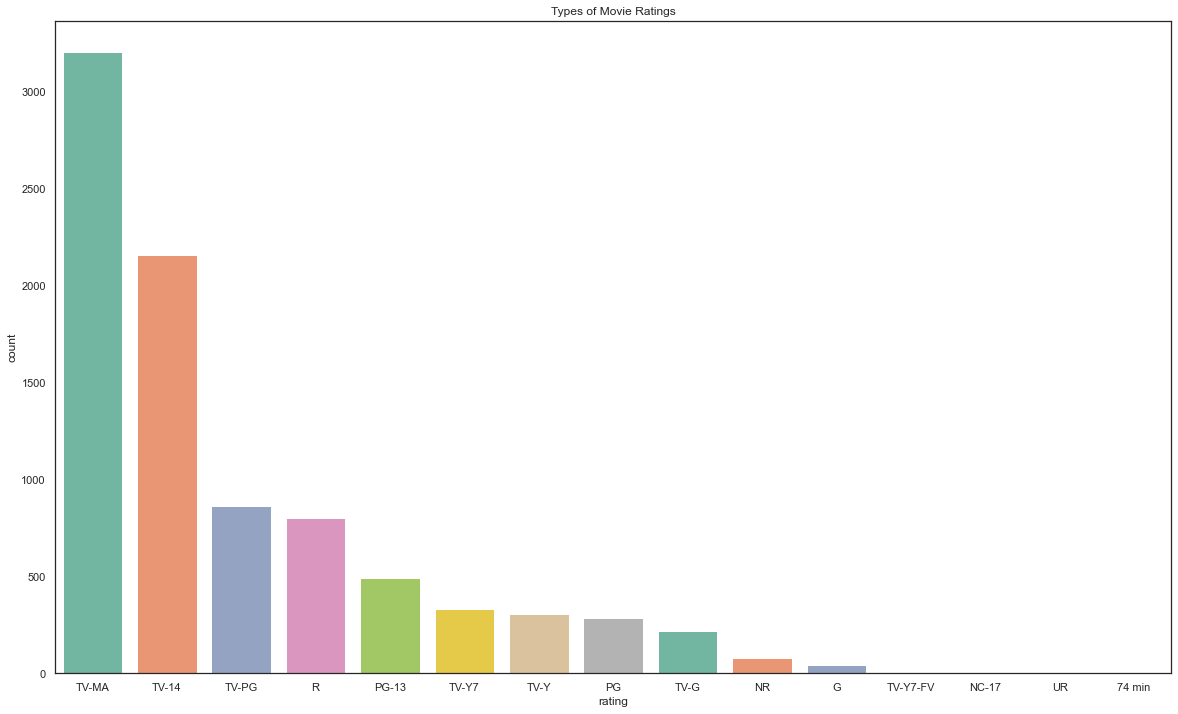

In [7]:
plt.figure(figsize=(20,12))
sns.set_style("white")
sns.countplot(x="rating", data=data, palette="Set2", order=data['rating'].value_counts().index[0:15]);
plt.title("Types of Movie Ratings");
plt.show();

# Recommendation Systems

There are several types of recommendation system techniques. Collaborative Filtering, Content Based Filtering and Hybrid Recommendation Systems being some of them. Each type of systems can be used to help predict or recommend a wide variety of products to consumers like similar movies or music. This Project is going to focus on Content Based Filtering.

<img src="./pictures/recommendation_system.png" style="height: 361px; width:420px; display: block; margin-left: auto; margin-right: auto"/>

# Content Based Filtering

Content-based filtering methods are based on the description of a product and a profile of the user preferred choices. Since this data set does not have any information about users, we will be finding recommendations for other movies based off a similarity metric of one movie to another.

<img src="./pictures/CBF.png" style="height: 482px; width:371px; display: block; margin-left: auto; margin-right: auto"/>

## Developing Recommendation Enging using director, cast, country, rating and listed_in (genre)

In [8]:
drop_columns = ['show_id', 'date_added', 'release_year', 'duration']
for col in drop_columns:
    data.drop(col, axis=1, inplace=True)

### Creating a Movie Feature Matrix

In [9]:
def calc_movie_feature_matrix(feature_column: pd.Series) ->  np.ndarray:
    """
    General Purpose Movie Feature Matrix function
    example: pass in data['director'], to get a similarity matrix (#movies, #directors)
    """

    isNan = False
    feature_list = []
    for i, items in enumerate(feature_column):
        if pd.isna(items):
            feature_list.append(['']) #place holder for nan values
            isNan = True
        else:
            item_list = re.split(r', \s*', items)
            feature_list.append(item_list)
        
    flatten_features = [item for sublist in feature_list for item in sublist]
    unique_features = list(np.unique(flatten_features))

    if isNan == True: # check if Nan value was passed through.
        unique_features = unique_features[1:] # '' is at index 0. this removes that value from list.
    
    index = {} #key: feature's name  value: column index
    for i, name in enumerate(unique_features):
        index[name] = i

    matrix = np.zeros((feature_column.shape[0], len(unique_features))) # (#movies, #unique features)
    for i, items in enumerate(feature_list): # update feature matrix with 1.0 where a movie has a particular feature. i.e specific director or actor. 
        movie = np.zeros(len(unique_features)) # movie array w/ all 0's
        if len(items) > 1:
            for item in items:
                movie[index[item]] = 1.0
            matrix[i] = movie
        elif items == ['']:
            matrix[i] = movie
        else:
            movie[index[items[0]]] = 1.0
            matrix[i] = movie
    return matrix

In [10]:
movie_director = calc_movie_feature_matrix(data['director'])
movie_cast = calc_movie_feature_matrix(data['cast'])
movie_country = calc_movie_feature_matrix(data['country'])
movie_rating = calc_movie_feature_matrix(data['rating'])
movie_genre = calc_movie_feature_matrix(data['listed_in'])
feature_matrix = np.concatenate((movie_director, movie_cast, movie_country, movie_rating, movie_genre), axis = 1)
print(f'Movie Feature Matrix shape: {feature_matrix.shape}')
print(feature_matrix)

Movie Feature Matrix shape: (8807, 41617)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Jaccard Similarity / Jaccard Index

The Jaccard Similarity Index is a measure of the similarity between two sets of data. It is a common proximity measurement used to compute the similarity between two objects, such as two text documents.

$$J(A,B) = {{|A \cap B|}\over{|A \cup B|}} = {{|A \cap B|}\over{|A| + |B| - |A \cap B|}}$$

In [11]:
def jaccsim(feature_matrix: pd.DataFrame) -> np.ndarray:
    """
    Create item-item similarity using Jaccard similarity
    J(A,B) = |A union B| / | A intersect B|
    """
    jacc_sim = np.zeros((feature_matrix.shape[0],feature_matrix.shape[0]))
    a = feature_matrix
    b = feature_matrix.T

    intersection = a @ b

    a_mag = a.sum(axis=1)
    a_mag= a_mag.reshape((len(a_mag),1))
    b_mag = b.sum(axis=0)

    union = (a_mag + b_mag) - intersection

    jacc_sim = np.divide(intersection, union, out=np.zeros_like(intersection), where=union!=0)

    return jacc_sim

## Cosine Similary
$$\text{cosine similarity} =S_C (A,B):= \cos(\theta) = {\mathbf{A} \cdot \mathbf{B} \over \|\mathbf{A}\| \|\mathbf{B}\|} = \frac{ \sum\limits_{i=1}^{n}{A_i  B_i} }{ \sqrt{\sum\limits_{i=1}^{n}{A_i^2}}  \sqrt{\sum\limits_{i=1}^{n}{B_i^2}} }$$


In [12]:
def cossim(feature_matrix: pd.DataFrame) -> np.ndarray:
    """
    Create item-item similarity using Cosine Similarity
    cossim = A dot B / ||A||*||B||
    """
    cos_sim = np.zeros((feature_matrix.shape[0],feature_matrix.shape[0]))
    a = feature_matrix
    b = feature_matrix.T
    
    numerator = a @ b
    
    a_mag = np.sqrt((a**2).sum(axis=1))     # ||A||
    a_mag = a_mag.reshape((len(a_mag),1))   # ||A|| reshaped to to help with matrix multiplication
    b_mag = np.sqrt((b**2).sum(axis=0))     # ||B||

    denominator = a_mag * b_mag             # ||A|| * ||B||

    cos_sim = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0) #      (A dot B) / ||A||*||B||  
    return cos_sim

## Creating Recommendation System Function 


In [13]:
def get_recommendation(title: str, similarity_matrix: np.ndarray) -> pd.DataFrame:
    """
    generates top 5 recommended movies to watch, based off of inputed title.
    title: string
    similarity_matrix: similarity function. ex: jacsim or cossim
    """
    if title in list(data['title']):
        movie_indices = pd.Series(data.index, index= data['title'])
        idx = movie_indices[title]
        sim_scores = enumerate(similarity_matrix[idx])
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        top_5_sim_scores = sim_scores[1:6]
        top_5_index = [x[0] for x in top_5_sim_scores]
        result = data.iloc[top_5_index]
        print(sim_scores[0:6])
        return result
    else:
        print('Title Not Found')

In [ ]:
jaccard_similarity = jaccsim(feature_matrix)
cosine_similarity = cossim(feature_matrix)

In [ ]:
get_recommendation('Austin Powers: International Man of Mystery', jaccard_similarity)

In [ ]:
get_recommendation('Dark', jaccard_similarity)

In [ ]:
get_recommendation('American Psycho', jaccard_similarity)

In [ ]:
get_recommendation('Stranger Things', cosine_similarity)

In [ ]:
get_recommendation('Hook', jaccard_similarity)

In [ ]:
get_recommendation('Peaky Blinders', cosine_similarity)

In [ ]:
# c_description = clean_text(data)
# tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df = 0.95, norm = 'l2')
# tfidf = tfidf_vectorizer.fit_transform(c_description)
# cos_sim = linear_kernel(tfidf, tfidf)

In [18]:
# get_recommendation('Peaky Blinders', cos_sim)

### TF-IDF

In [19]:
tv_shows = data[data['type'] == 'TV Show']
movies = data[data['type'] == 'Movie']
tv_shows.reset_index(inplace=True)
movies.reset_index(inplace=True)

In [20]:
def clean_text(df: pd.Series) -> pd.Series:
    stop_words = stopwords.words('english')
    removed_stop_words = df['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    cleaned_description = []
    for i, v in enumerate(removed_stop_words):
        lower_case_desc = v.lower()
        cleaned_description.append(lower_case_desc) 
    df = df.assign(c_description=cleaned_description)
    return df.c_description

In [21]:
def clean_text2(df: pd.Series) -> pd.Series: #with lementing, but made shit worse
    wordnet_lemmatizer = WordNetLemmatizer()
    
    stop_words = stopwords.words('english')
    removed_stop_words = df['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    cleaned_description = []
    for i, v in enumerate(removed_stop_words):
        string = re.sub(r'[^-\w\s]+', '', removed_stop_words[i]) #
        string = re.sub(r'[^\w\s]+', ' ', string) #replaced - with space
        string = re.sub(' +', ' ', string) #removes any extra space
        lower_case_desc = string.lower()
        token_text = word_tokenize(lower_case_desc)
        lem = [wordnet_lemmatizer.lemmatize(word.lower()) for word in token_text] 
        cleaned_description.append(" ".join(lem)) 
    df = df.assign(c_description=cleaned_description)
    return df.c_description


    

In [22]:
c_description = clean_text(tv_shows)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df = 0.95, norm = 'l2')
tfidf = tfidf_vectorizer.fit_transform(c_description)
cos_sim = linear_kernel(tfidf, tfidf)

In [23]:
def get_recommendation_tv(title: str, similarity_matrix: np.ndarray) -> pd.DataFrame:
        if title in list(tv_shows['title']):
            movie_indices = pd.Series(tv_shows.index, index= tv_shows['title'])
            idx = movie_indices[title]
            sim_scores = enumerate(similarity_matrix[idx])
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            top_5_sim_scores = sim_scores[1:6]
            top_5_index = [x[0] for x in top_5_sim_scores]
            result = tv_shows.iloc[top_5_index]
            print(sim_scores[0:6])
            return result
        else:
            print('Title Not Found')

In [24]:
def get_recommendation_movie(title: str, similarity_matrix: np.ndarray) -> pd.DataFrame:
        if title in list(data['title']):
            movie_indices = pd.Series(movies.index, index= movies['title'])
            idx = movie_indices[title]
            sim_scores = enumerate(similarity_matrix[idx])
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            top_5_sim_scores = sim_scores[1:6]
            top_5_index = [x[0] for x in top_5_sim_scores]
            result = movies.iloc[top_5_index]
            print(sim_scores[0:6])
            return result
        else:
            print('Title Not Found')

In [25]:
get_recommendation_tv('After Life', cos_sim)

[(64, 1.0), (2359, 0.23300665026325257), (2071, 0.16020843294637402), (1228, 0.15911713296343213), (321, 0.12636237511246606), (2069, 0.11626680358555272)]


,index,type,title,director,cast,country,rating,listed_in,description
2359,7637,TV Show,Winter Sun,NaN,"Şükrü Özyıldız, Aslı Enver, Şenay Gürler, Başa...",Turkey,TV-MA,"International TV Shows, TV Dramas, TV Thrillers",Years after ruthless businessmen kill his fath...
2071,6739,TV Show,The Paper,NaN,"Branka Katić, Trpimir Jurkic, Aleksandar Cvetk...",Croatia,TV-MA,"International TV Shows, TV Dramas",A construction magnate takes over a struggling...
1228,4048,TV Show,Merry Happy Whatever,NaN,"Dennis Quaid, Bridgit Mendler, Brent Morin, As...",United States,TV-PG,TV Comedies,A struggling LA musician tries to win over his...
321,1193,TV Show,"Can't Cope, Won't Cope",NaN,"Seána Kerslake, Nika McGuigan, Sheila Moylette...",Ireland,TV-MA,"TV Comedies, TV Dramas","In Dublin, friends Aisling and Danielle must c..."
2069,6727,TV Show,The Originals,NaN,"Joseph Morgan, Daniel Gillies, Phoebe Tonkin, ...",United States,TV-14,"TV Dramas, TV Horror, TV Mysteries",The Mikaelsons move to New Orleans and form an...


In [26]:
get_recommendation_tv('After Life', cos_sim)

[(64, 1.0), (2359, 0.23300665026325257), (2071, 0.16020843294637402), (1228, 0.15911713296343213), (321, 0.12636237511246606), (2069, 0.11626680358555272)]


,index,type,title,director,cast,country,rating,listed_in,description
2359,7637,TV Show,Winter Sun,NaN,"Şükrü Özyıldız, Aslı Enver, Şenay Gürler, Başa...",Turkey,TV-MA,"International TV Shows, TV Dramas, TV Thrillers",Years after ruthless businessmen kill his fath...
2071,6739,TV Show,The Paper,NaN,"Branka Katić, Trpimir Jurkic, Aleksandar Cvetk...",Croatia,TV-MA,"International TV Shows, TV Dramas",A construction magnate takes over a struggling...
1228,4048,TV Show,Merry Happy Whatever,NaN,"Dennis Quaid, Bridgit Mendler, Brent Morin, As...",United States,TV-PG,TV Comedies,A struggling LA musician tries to win over his...
321,1193,TV Show,"Can't Cope, Won't Cope",NaN,"Seána Kerslake, Nika McGuigan, Sheila Moylette...",Ireland,TV-MA,"TV Comedies, TV Dramas","In Dublin, friends Aisling and Danielle must c..."
2069,6727,TV Show,The Originals,NaN,"Joseph Morgan, Daniel Gillies, Phoebe Tonkin, ...",United States,TV-14,"TV Dramas, TV Horror, TV Mysteries",The Mikaelsons move to New Orleans and form an...


In [27]:
get_recommendation_movie('Hook', cos_sim)

[(1941, 0.9999999999999996), (1435, 0.11609816342652843), (729, 0.10771714480538544), (779, 0.10478164023365995), (1927, 0.09492108475745697), (1013, 0.09357276763381683)]


,index,type,title,director,cast,country,rating,listed_in,description
1435,2042,Movie,Evening Shadows,Sridhar Rangayan,"Mona Ambegaonkar, Anant Mahadevan, Devansh Dos...",India,TV-PG,"Dramas, Independent Movies, International Movies","When her son comes out to her as gay, a religi..."
729,974,Movie,Bleach The Movie: Fade to Black,Noriyuki Abe,"Masakazu Morita, Fumiko Orikasa, Aya Hirano, H...",Japan,TV-PG,"Action & Adventure, Anime Features, Sci-Fi & F...",When his mind is fogged by a scimitar-weilding...
779,1053,Movie,Born Beautiful,Perci Intalan,"Martin del Rosario, Lou Veloso, Chai Fonacier,...",Philippines,TV-MA,"Comedies, Dramas, International Movies","After her best friend dies, Barbs attempts to ..."
1927,2780,Movie,Holy Goalie,Curro Velázquez,"Karra Elejalde, Alain Hernández, Juan Manuel M...",Spain,TV-MA,"Comedies, International Movies, Sports Movies",A young priest coaches a team of uncoordinated...
1013,1402,Movie,City of Joy,Madeleine Gavin,NaN,"United States,",TV-MA,Documentaries,Women who've been sexually brutalized in war-t...


In [28]:
# def calc_movie_cast_matrix():
#     movie_cast = []
#     for i, names in enumerate(data['cast']):
#         if pd.isna(names):
#             movie_cast.append(['']) #place holder for nan values
#         else:
#             cast_members = re.split(r', \s*', names)
#             movie_cast.append(cast_members)

#     actors = [item for sublist in movie_cast for item in sublist]
#     unique_actors = list(np.unique(actors))
#     unique_actors = unique_actors[1:] # '' is at index 0. this removes that value from list.

#     index = {} #key: actor's name value: column index
#     for i, name in enumerate(unique_actors):
#         index[name] = i

#     matrix = np.zeros((7787, len(unique_actors))) #(#movies, #unique actors)

#     for i , names in enumerate(movie_cast):
#         movie = np.zeros(len(unique_actors))
#         if len(names) > 1:
#             for name in names:
#                 movie[index[name]] = 1.0
#             matrix[i] = movie
#         elif names == ['']:
#             matrix[i] = movie 
#         else:
#             movie[index[names[0]]] = 1.0
#             matrix[i] = movie

#     return matrix

In [29]:
# # creates a movie director matrix of shape (7787, 4478)
# def create_movie_director():
#     movie_directors = []
#     for i, names in enumerate(data['director']):
#         if pd.isna(names):
#             movie_directors.append(['']) #place holder for Nan values
#         else:
#             director = re.split(r', \s*', names)
#             movie_directors.append(director)

#     all_directors = [item for sublist in movie_directors for item in sublist]
#     unique_directors = list(np.unique(all_directors))
#     unique_directors = unique_directors[1:]


#     index = {} # key: director name value: column index.
#     for i, name in enumerate(unique_directors):
#         index[name] = i

#     matrix = np.zeros((7787, len(unique_directors))) # (#movies, #uniquedirectors)

#     for i , names in enumerate(movie_directors):
#         movie = np.zeros(len(unique_directors))
#         if len(names) > 1:
#             for name in names:
#                 movie[index[name]] = 1.0
#             matrix[i] = movie
#         elif names == ['']:
#             matrix[i] = movie 
#         else:
#             movie[index[names[0]]] = 1.0
#             matrix[i] = movie
            
#     return matrix

In [30]:
# create_movie_director().shape

In [31]:
# # creates a movie, director matrix of shape (7787,4049)
# def create_movie_director():
        
#     unique_directors = [] #gets all unique director names
#     for name in data['director'].unique():
#         if pd.notna(name):
#             unique_directors.append(name)

#     index = {} # key: director name value: columns index.
#     for i, name in enumerate(unique_directors):
#         index[name] = i


#     matrix = np.zeros((7787, 4049)) # (#movies, #uniquedirectors)

#     for i , name in enumerate(data['director']):
#         movie = np.zeros(len(unique_directors))
#         if pd.isna(name):
#             matrix[i] = movie 
#         else:
#             movie[index[name]] = 1.0
#             matrix[i] = movie
            
#     return matrix
